<h1 align="center"><font color='#355C7D'>Automatically Masking Cartridge Case Images</font></h1>

<h4 align="center">Tommy Flynn | tommyflynn@rogers.com | 519-209-1361 |  <a href=https://www.linkedin.com/in/tfln>LinkedIn</a></h4>

- First, we import the required libraries: 
    - __OpenCV__ for image processing.
    - __NumPy__ for numerical computation.
    - __Matplotlib__ for data visualization.

In [67]:
import cv2                          # Image processing 
import numpy as np                  # Numerical computation 
import matplotlib.pyplot as plt     # Data visualization 
np.random.seed(13)                 

def see(image, title=None, figsize=(4.5, 4.5), dpi=100):
    # This will provide quick visualization of images with adjustable resolution.
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.show()

- Next, we load in the fired cartridge case image and visualize it.

Image Dimensions: (716, 730, 3)


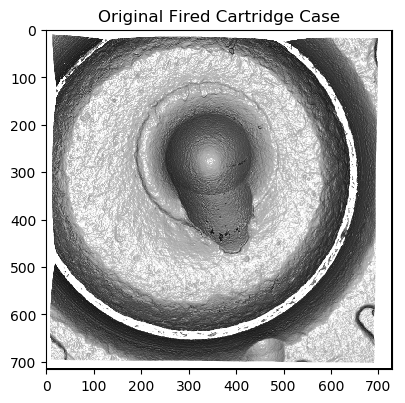

In [68]:
original = cv2.imread('before_masking.png')     # Load Image 
n, p, c = np.shape(original)                    # Dimensions 

print(f'Image Dimensions: {(n,p,c)}')
see(original, 'Original Fired Cartridge Case')                                                   

- Notice that the outer boundaries enclosing the breech face impression and firing pin impression are roughly circular.
- Let's process the image to accentuate these regions and then apply a circle detector.  

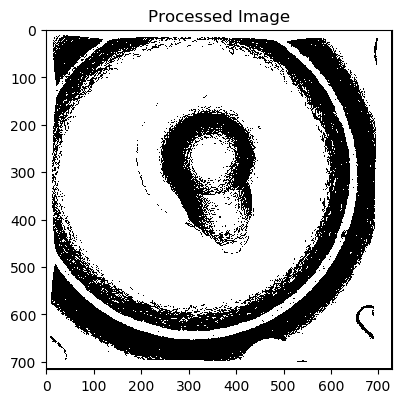

In [69]:
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)               # Convert to grayscale 
_, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)    # Highlight regions of interest
equ = cv2.equalizeHist(thresh)                                  # Enhance contrast

see(equ, 'Processed Image')

- To search for circles in the processed image we use the Circle Hough Transform, which specialized in circular feature extraction.  

In [70]:
def detect_circle(image, min_rad, max_rad, color):
    # Searches for circles in the image within min_rad to max_rad. 
    # A mask is then created using the best circle.

     # Detect circles   
    circles = cv2.HoughCircles(
        image, 
        cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=20,  
        param1=50,  
        param2=15,  
        minRadius=min_rad,  
        maxRadius=max_rad)  
                                                   
    # Select best circle 
    circle = np.uint16(np.around(circles[0][0]))                            
    center = [circle[0], circle[1]]                                          
    radius = circle[2]                                                      

    # Create circular mask 
    circular_mask = np.zeros((n, p, 3), dtype=np.uint8)                      
    cv2.circle(circular_mask, center, radius, color, thickness=-1)         
    circular_mask_gray = cv2.cvtColor(circular_mask, cv2.COLOR_BGR2GRAY)    
    circular_mask_gray[np.where(circular_mask_gray != 0)] = 255
    return [circular_mask, circular_mask_gray, radius, center]

# Breech face mask 
bf_mask, bf_gray, bf_rad, bf_center = detect_circle(equ, int(max(n, p)/4), 0, (15, 21, 139))
# Firing pin mask 
fp_mask, fp_gray, fp_rad, fp_center = detect_circle(equ, 0, int(bf_rad/2), (67, 47, 60))

- The current region of interest lies within these circles. 
- Let's create an annular mask to extract this area. 

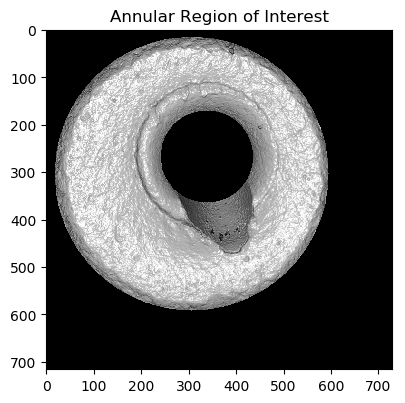

In [71]:
annular_mask = cv2.subtract(bf_gray, fp_gray)
roi = cv2.bitwise_and(gray, gray, mask=annular_mask)

see(roi, 'Annular Region of Interest')

- There appears to be a small map pin icon formed by the firing pin impression and its drag mark.
- There is also a large map pin icon formed by a slightly larger circle and the drag mark.   
- To extract these regions, we process them and perform edge detection.

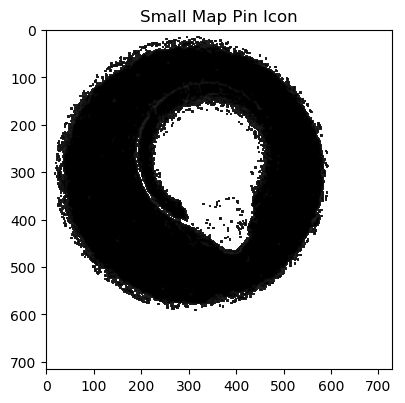

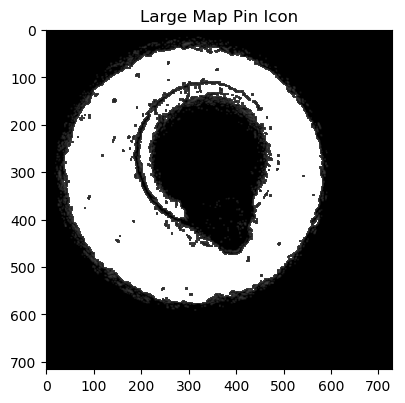

In [72]:
_, thresh = cv2.threshold(255 - roi, 100, 255, cv2.THRESH_BINARY) 
blurred_small = cv2.GaussianBlur(thresh, (5, 5), 0)
equ_small = cv2.equalizeHist(blurred_small)
k = 255 - thresh
blurred_large = cv2.GaussianBlur(k, (5, 5), 0)
equ_large = cv2.equalizeHist(blurred_large)

see(equ_small, 'Small Map Pin Icon')
see(equ_large, 'Large Map Pin Icon')

- To create masks of these regions, we use a combination of Canny edge detection and contour filling. 

In [73]:
def map_pin_mask(image, color):
    # Creates mask using edge detection and contour filling. 
    edges = cv2.Canny(image, 50, 150)                                                   
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    
    largest_contour =  max(contours, key=cv2.contourArea)                               
    pin_mask = np.zeros((n,p,3), dtype=np.uint8)                                        
    hull = cv2.convexHull(largest_contour)
    cv2.drawContours(pin_mask, [hull], 0,  color, thickness=cv2.FILLED)
    pin_mask_gray = cv2.cvtColor(pin_mask, cv2.COLOR_BGR2GRAY) 
    return(pin_mask, pin_mask_gray, hull)

# Large map pin mask 
mp_large, mp_large_gray, hull_large = map_pin_mask(equ_large, (0, 95, 0))
# Small map pin mask
mp_small, mp_small_gray, hull_small = map_pin_mask(equ_small, (130, 134, 77))

- Finally, we color the original image using the regions we have created:

1. __Breech face impression:__  <br>
     - Obtained by subtracting the large map pin icon from its outer circle. <br><br>
2. __Aperture shear:__ <br>
     - Obtained by subtracting the small map pin icon from the large map pin icon.  <br><br>
3. __Direction of the firing pin drag:__ <br>
     - Defined by the line connecting the center of the firing pin circle to the point of greatest distance in the small map pin icon. <br><br>
4. __Firing pin impression:__ <br>
     - Obtained from its outer circle. <br><br>
5. __Firing pin drag:__ <br> 
     - Defined by all points on the small map pin icon whose distance is:
        - Outside of the firing pin impression.
        - Within the length of the direction line away from the farthest drag point.
        - Within the firing pin radius away from the drag line.

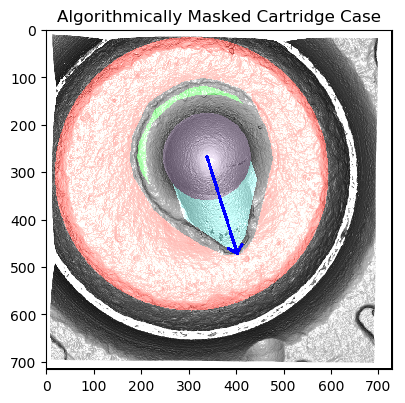

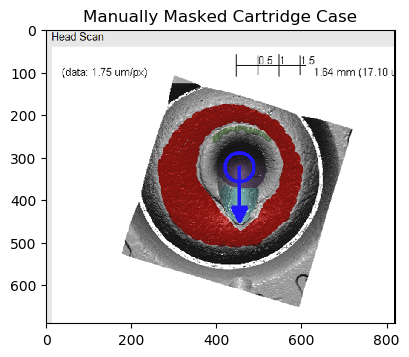

In [74]:
# Breech face impression 
breech_face = bf_mask
breech_face[np.where(mp_large_gray != 0)] = [0, 0, 0]

# Aperture shear
aperture_shear = mp_large 
aperture_shear[np.where(mp_small_gray != 0)] = [0, 0, 0]
aperture_shear = cv2.erode(aperture_shear, np.ones((5, 5), np.uint8), iterations=7)

# Direction of the firing pin drag
farthest_point = None
max_distance = 0
for pt in hull_small:
    distance = np.sqrt((fp_center[0] - pt[0][0])**2 + (fp_center[1] - pt[0][1])**2)
    if distance > max_distance:
        max_distance = distance
        farthest_point = (pt[0][0], pt[0][1])

# Firing pin 
def distance_to_line(point1, point2, reference_point):
    # Calculates the distance between the reference point and the line defined by point1 and point2. 
    x1, y1 = point1
    x2, y2 = point2
    x0, y0 = reference_point
    A = y1 - y2
    B = x2 - x1
    C = x1 * y2 - x2 * y1
    numerator = abs(A * x0 + B * y0 + C)
    denominator = np.sqrt(A**2 + B**2)
    distance = numerator / denominator
    return distance

firing_pin = mp_small.copy()
y, x = np.ogrid[:n, :p]
# Removes points farther than fp_rad from the direction line 
distance1 = np.fromfunction(lambda i, j: distance_to_line(farthest_point, fp_center, (j, i)) > fp_rad, (n, p))
firing_pin[distance1] = [0, 0, 0]
# Remove points farther than direction line.
distance2 = np.sqrt((x - farthest_point[0]) ** 2 + (y - farthest_point[1]) ** 2) > (max_distance)
firing_pin[distance2] = [0, 0, 0] 
firing_pin = cv2.erode(firing_pin, np.ones((10, 10), np.uint8), iterations=2)
# Add firing pin impression 
fp_gray = cv2.erode(fp_gray, np.ones((5, 5), np.uint8), iterations=2)
firing_pin[np.where(fp_gray != 0)] = [67, 47, 60]

# Color original image 
alpha = 0.95
colored_image = cv2.addWeighted(original, 1, breech_face, alpha, 0)
colored_image = cv2.addWeighted(colored_image, 1, aperture_shear, alpha, 0)
colored_image = cv2.addWeighted(colored_image, 1, firing_pin, alpha, 0)
cv2.arrowedLine(colored_image, fp_center, farthest_point, (255, 0, 0), 6, tipLength=0.1)

see(colored_image, 'Algorithmically Masked Cartridge Case')
see(cv2.imread('after_masking.png'), 'Manually Masked Cartridge Case')